<a href="https://colab.research.google.com/github/yilmazgencc/recomender_system/blob/main/recommender_tf_MSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [ ]:
def dataset_prep(df):
    user_ids = df["userId"].unique().tolist()
    user2user_encoded = {x: i for i, x in enumerate(user_ids)}
    userencoded2user = {i: x for i, x in enumerate(user_ids)}
    movie_ids = df["movieId"].unique().tolist()
    movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
    movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
    df["user"] = df["userId"].map(user2user_encoded)
    df["movie"] = df["movieId"].map(movie2movie_encoded)

    num_users = len(user2user_encoded)
    num_movies = len(movie_encoded2movie)
    df["rating"] = df["rating"].values.astype(np.float32)
    # min and max ratings will be used to normalize the ratings later
    min_rating = min(df["rating"])
    max_rating = max(df["rating"])

    print(
        "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
            num_users, num_movies, min_rating, max_rating
        )
    )
    return num_users, num_movies, df ,min_rating, max_rating

In [ ]:
movielens_zipped_file="/content/drive/MyDrive/ml-1m.zip"
movielens_dir=movielens_zipped_file[:-4]
if not os.path.isdir(movielens_dir):
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(Path(movielens_dir).parents[0])
        print("Done!")

pd.options.display.max_rows = 10
# unames = ['userId', 'gender', 'age', 'occupation', 'zip']
# users = pd.read_table(os.path.join(movielens_dir, "users.dat"), sep='::', header=None, names=unames, engine='python')
rnames = ['userId', 'movieId', 'rating', 'timestamp']
df = pd.read_table(os.path.join(movielens_dir, "ratings.dat"), sep='::', header=None, names=rnames, engine='python')
#ratings
# mnames = ['movieId', 'title', 'genres']
# movies = pd.read_table(os.path.join(movielens_dir, "movies.dat"), sep='::', header=None, names=mnames, engine='python')

num_users, num_movies, df, min_rating, max_rating=dataset_prep(df)

Number of users: 6040, Number of Movies: 3706, Min rating: 1.0, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 100
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.SGD(lr=0.001) , metrics=['accuracy', 'mse']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
EMBEDDING_SIZE = 100
class RecommenderNet_withNN(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, H1, D_out, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

        #linear layer adding

        self.linear1=layers.Dense(embedding_size*2, H1)
        self.linear2=layers.Dense(H1, D_out)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=0.0001) , metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError()]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/100
1563/1563 [==============================] - 16s 6ms/step - loss: 0.0888 - accuracy: 0.1979 - root_mean_squared_error: 0.2973 - val_loss: 0.0763 - val_accuracy: 0.2262 - val_root_mean_squared_error: 0.2756
Epoch 2/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0755 - accuracy: 0.2263 - root_mean_squared_error: 0.2741 - val_loss: 0.0813 - val_accuracy: 0.2319 - val_root_mean_squared_error: 0.2845
Epoch 3/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0725 - accuracy: 0.2263 - root_mean_squared_error: 0.2686 - val_loss: 0.0763 - val_accuracy: 0.2330 - val_root_mean_squared_error: 0.2755
Epoch 4/100
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0702 - accuracy: 0.2264 - root_mean_squared_error: 0.2643 - val_loss: 0.0739 - val_accuracy: 0.2379 - val_root_mean_squared_error: 0.2712
Epoch 5/100
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0683 - accuracy: 0.2271 - root_mean_squared_error: 0

dict_keys(['loss', 'accuracy', 'root_mean_squared_error', 'val_loss', 'val_accuracy', 'val_root_mean_squared_error'])


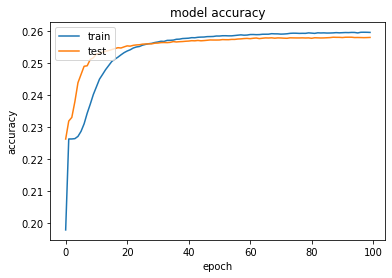

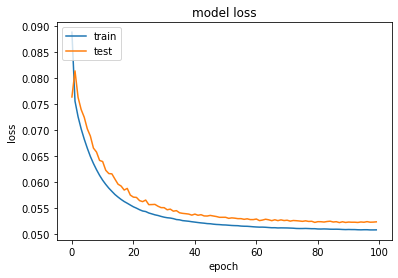

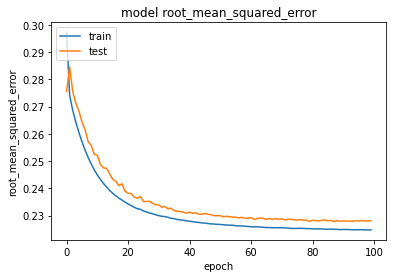

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val),
)
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
